## 混合概率模型的例子

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy import integrate as inte

In [3]:
from mpl_toolkits.mplot3d import Axes3D

In [4]:
%matplotlib notebook
#%matplotlib inline

In [5]:
X = np.random.randn(3000,3)

<IPython.core.display.Javascript object>


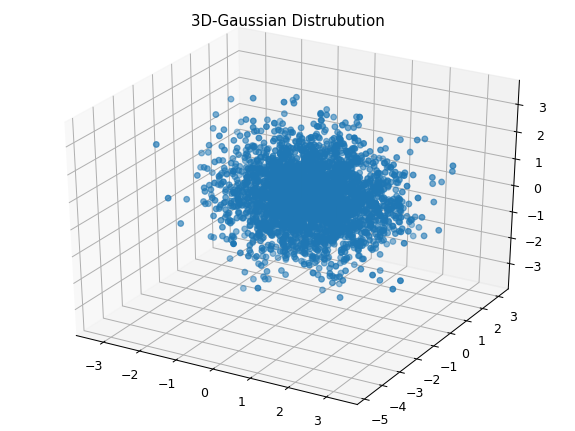

In [6]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:,0], X[:,1], X[:,2])
plt.title('3D-Gaussian Distrubution')

# 单高斯模型逼近混合高斯模型

In [10]:
class Gaussian:
    """N-dimensinal Gaussian Distribution
    """
    def __init__(self, u, Sigma):
        self.dim = len(u)
        self.u = u.reshape(self.dim,)
        self.sigma = Sigma
        self.a = 1/ np.sqrt( (2*np.pi)**(self.dim) * np.linalg.det(self.sigma) )
        self.inv = np.linalg.inv(self.sigma)
        
    def __call__(self, x):
        return self.a * np.exp(np.sum(-(x-self.u).dot(self.inv) * (x-self.u), axis=1) )

In [11]:
# 混合模型的组成之一 N(-2,2)
u1 = np.array([-2])
v1 = np.array([[2]])
g1 = Gaussian(u1,v1)

In [12]:
# 混合模型的组成之一 N(2,2)
u2 = np.array([2])
v2 = np.array([[2]])
g2 = Gaussian(u2,v2)

In [13]:
# 
pc1 = 0.5
pc2 = 0.5

In [14]:
x = np.linspace(-5,5, 100).reshape(-1,1)

In [15]:
y1 = g1(x)
y2 = g2(x)
y = y1 * pc1 + y2 * pc2

In [16]:
# 混合高斯模型的函数
def MixedG(g1, g2, pc1, pc2):
    def _get(x):
        return g1(x) * pc1 + g2(x) * pc2
    return _get

<IPython.core.display.Javascript object>


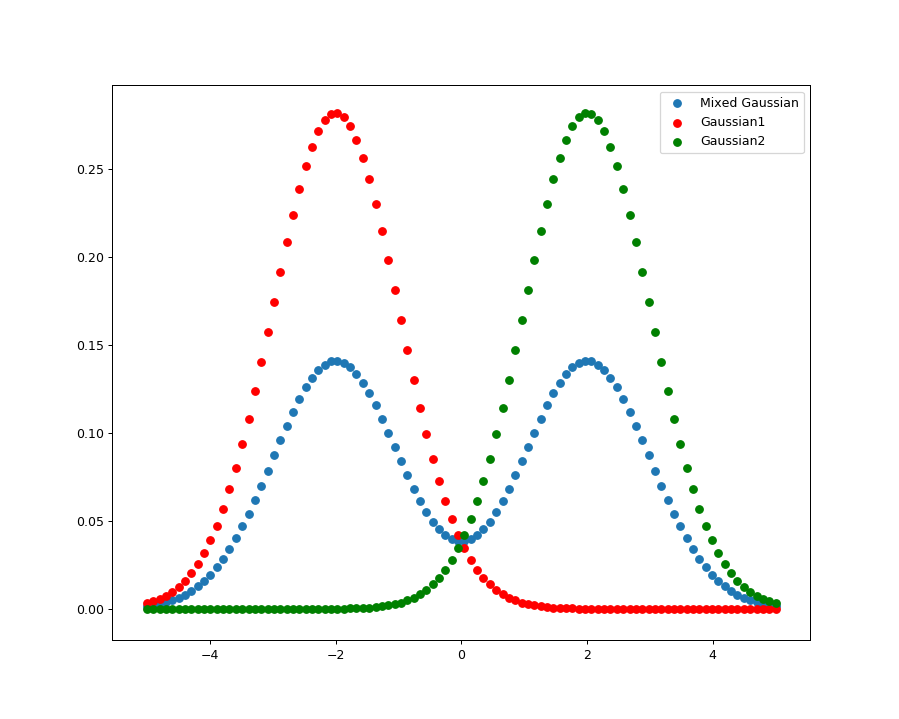

In [17]:
fig = plt.figure(figsize=(10,8))
plt.scatter(x,y, label='Mixed Gaussian')
plt.scatter(x, y1, c='r', label='Gaussian1')
plt.scatter(x, y2, c='g', label='Gaussian2')
plt.legend()
plt.show()

In [18]:
# 封装得到一维高斯分布
def OneDGaussian(u, var):
    u = np.array([u])
    v = np.array([[var]])
    return Gaussian(u,v)

In [19]:
# KL 散度的衡量公式
p = MixedG(g1, g2, pc1, pc2) # 高斯混合模型
# 初值
u_inti = 0.0
var_inti = 1.0
q = OneDGaussian(u_inti, var_inti) # N(u, var)的单高斯模型

In [20]:
# 采用近似的计算方法求KL散度f(x),接下来还要对f(x)积分才得到KL散度
def fullf(p, q):
    def __call__(x):
        return (np.log2(p(x)) - np.log2(q(x))) * p(x)
    return __call__

In [21]:
def Nakfullf(p,q):
    def __call__(x):
        return (np.log2(q(x)) - np.log2(p(x))) * p(x)
    return __call__

In [22]:
f = fullf(p,q)

In [23]:
def quad(f, down, up, delta=10e-3, delta_num = 100000):
    """使用Simpson公式对区间[down, up]上函数f积分
    """
    x = np.arange(down, up, delta)
    x = x.reshape(-1,1)
    medianx = x + delta / 2
    medianx = medianx.reshape(-1,1)
    x = x.reshape(-1,1)
    a = f(x)
    b = np.zeros_like(a)
    b[:-1] = a[1:]
    b[-1] = a[-1]
    c = f(medianx)
    
    # 梯形公式
    c = (a + b + 4*c) / 6
    return np.sum(c[:-1]) * delta

In [24]:
quad(f, -1,2, delta=10e-3) # example

-0.028792205955770207

In [25]:
# 由于我们的混合模型的边缘的概率已经很低了，所以我们取得区间[-20,20]即可
quad(f, -20,20, delta=10e-3)

3.5916112908023763

## 使用梯度下降求解

In [26]:
# 在这里使用数值上的微分，但是其实最好不要这么使用
def GradientDescent(cost, initial_x, lr, iternum = 100):
    
    def grad(f, x, delta = 10e-4):
        """使用中心差商公式求数值微分"""
        m = x.size
        u,var = x[0],x[1]
        du =  ( f((u+delta , var)) - f((u-delta, var)) ) / ( 2*delta)
        dvar = ( f((u, var+delta)) - f((u, var-delta))) / (2*delta)
        return np.array((du,dvar))
    
    step = iternum // 10
    
    x = initial_x
    for i in range(iternum):
        gradient = grad(cost, x)
        x = x - lr * gradient
        
        if i % step == 0:
            print(x)
        
    return x

In [27]:
# 给出cost的完整函数
def LKLcost_func(p):
    """p 是给定的双峰的高斯混合模型，我们使用q去逼近它
    """
    def __call__(x):
        q = OneDGaussian(*x)
        f = fullf(p,q)
        return quad(f, -20, 20)
    return __call__

## 求解选择左KL散度${KL(p||q)}$作为cost的情况下的变化

给定需要拟合的混合高斯模型p

In [28]:
# 混合模型的组成之一 N(-2,2)
u1 = np.array([-3])
v1 = np.array([[2]])
g1 = Gaussian(u1,v1)

In [29]:
# 混合模型的组成之一 N(2,2)
u2 = np.array([2])
v2 = np.array([[1]])
g2 = Gaussian(u2,v2)

In [30]:
# 
pc1 = 0.6
pc2 = 0.4

In [31]:
p = MixedG(g1, g2, pc1, pc2) # 混合高斯模型p

In [32]:
x = np.linspace(-5,5, 100).reshape(-1,1)
y1 = g1(x)
y2 = g2(x)
y = y1 * pc1 + y2 * pc2

<IPython.core.display.Javascript object>


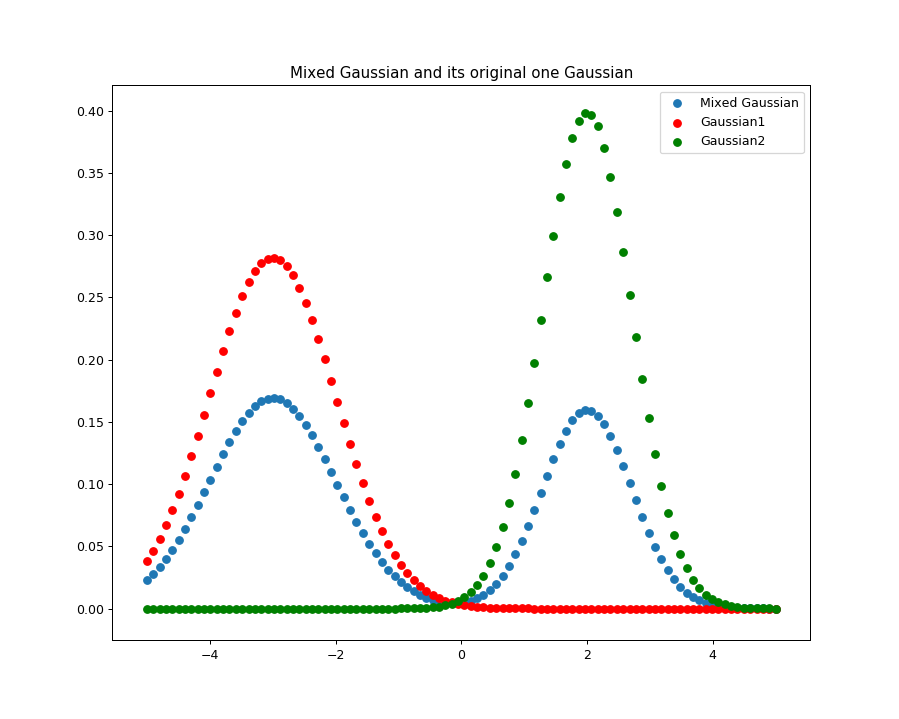

In [33]:
fig = plt.figure(figsize=(10,8))
plt.scatter(x,y, label='Mixed Gaussian')
plt.scatter(x, y1, c='r', label='Gaussian1')
plt.scatter(x, y2, c='g', label='Gaussian2')
plt.title('Mixed Gaussian and its original one Gaussian')
plt.legend()
plt.show()

In [34]:
cost = LKLcost_func(p)

In [35]:
## 直观地感受cost随 均值和方差的变化图
u_x = np.linspace(2*u1, 2*u2, 100)
var_x = np.linspace(1, 2*2, 100)

In [36]:
# cost 随均值的变化曲线
c = np.zeros_like(u_x)
for i, ux in enumerate(u_x):
    c[i] = cost((ux, var_x[0]))

<IPython.core.display.Javascript object>


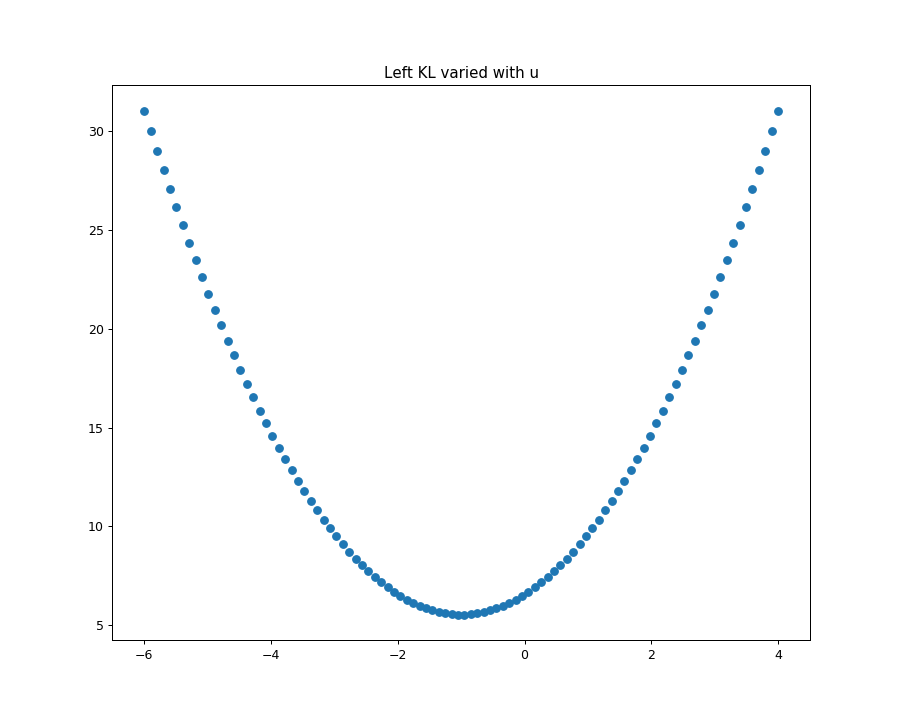

In [37]:
fig = plt.figure(figsize = (10,8))
plt.scatter(u_x, c)
plt.title('Left KL varied with u')

In [38]:
# cost 随方差的变化曲线
c = np.zeros_like(var_x)
for i, varx in enumerate(var_x):
    c[i] = cost((u_x[0], varx))

<IPython.core.display.Javascript object>


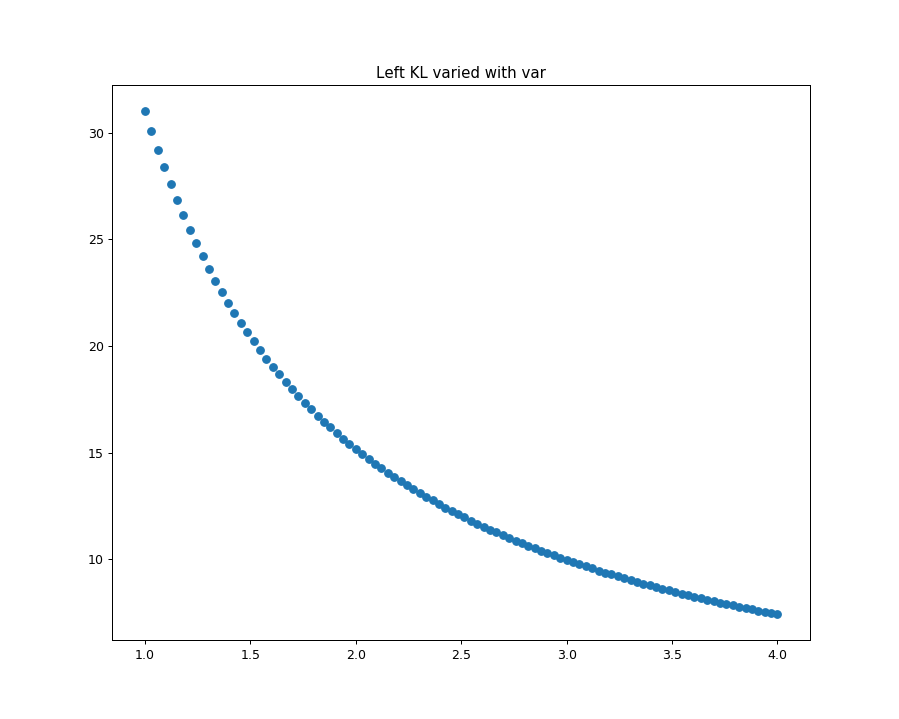

In [39]:
#
fig = plt.figure(figsize = (10,8))
plt.scatter(var_x, c)
plt.title('Left KL varied with var')

我们可以看到：使用左KL散度作为cost，在实验的范围内，单个的高斯分布模型的参数${\mu}$在偏导方向上是趋向中间化，而${var}$在偏导方向上是越大越好

In [40]:
# 画出函数cost(x,y)的三维图像
ux = np.linspace(2*u1, 2*u2, 100)
varx = np.linspace(1, 5, 100)
ux,varx = np.meshgrid(ux,varx)

In [41]:
z = np.zeros_like(ux)
m,n = z.shape
for i in range(m):
    for j in range(n):
        z[i,j] = cost((ux[i,j], varx[i,j]))

<IPython.core.display.Javascript object>


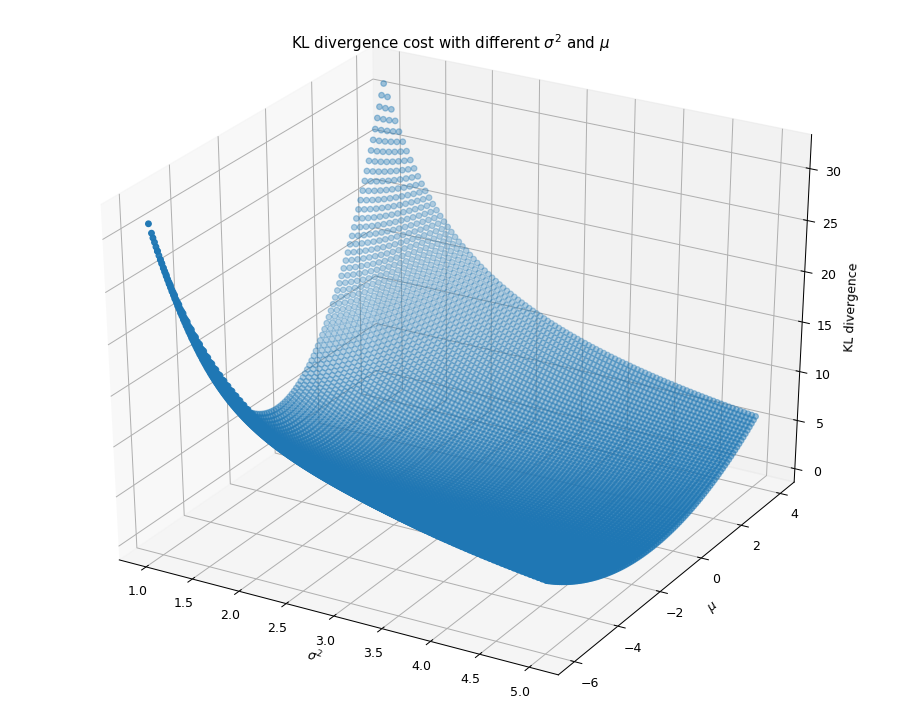

In [46]:
# plot
fig = plt.figure(figsize = (10,8))
ax = Axes3D(fig)
ax.set_zlabel('KL divergence')
ax.scatter(varx,ux, z)
plt.xlabel('${\sigma^{2}}$')
plt.ylabel('${\mu}$')
plt.title('KL divergence cost with different $\sigma^{2}$ and $\mu$')

这张图十分清晰地表明了函数的关系

接下来使用梯度下降求解最优值

In [47]:
initial_x = np.array([1,1])

In [48]:
c = GradientDescent(cost, initial_x, 0.002, iternum=10000)

[ 0.99183888  1.02101489]
[-0.59505699  3.42659819]
[-0.86185597  4.13320788]
[-0.94554813  4.62375891]
[-0.97665322  5.00963318]
[-0.98939514  5.33109218]
[-0.99497088  5.60818656]
[-0.99753283  5.85257278]
[-0.99875573  6.07169947]
[-0.99935777  6.27064684]


In [49]:
c

array([-0.99966166,  6.45287537])

In [51]:
iq = OneDGaussian(*initial_x)
q = OneDGaussian(*c)

In [52]:
def draw(p,q, down = -5, up = 5):
    """画出原分布和近似的高斯分布"""
    fig = plt.figure(figsize=(10,8))
    x = np.linspace(down, up, 1000)
    x = x.reshape(-1,1)
    y1 = p(x)
    y2 = q(x)
    plt.scatter(x,y1, label='original distribution')
    plt.scatter(x,y2, label='approximated distribution')
    plt.legend()
    return plt

<IPython.core.display.Javascript object>


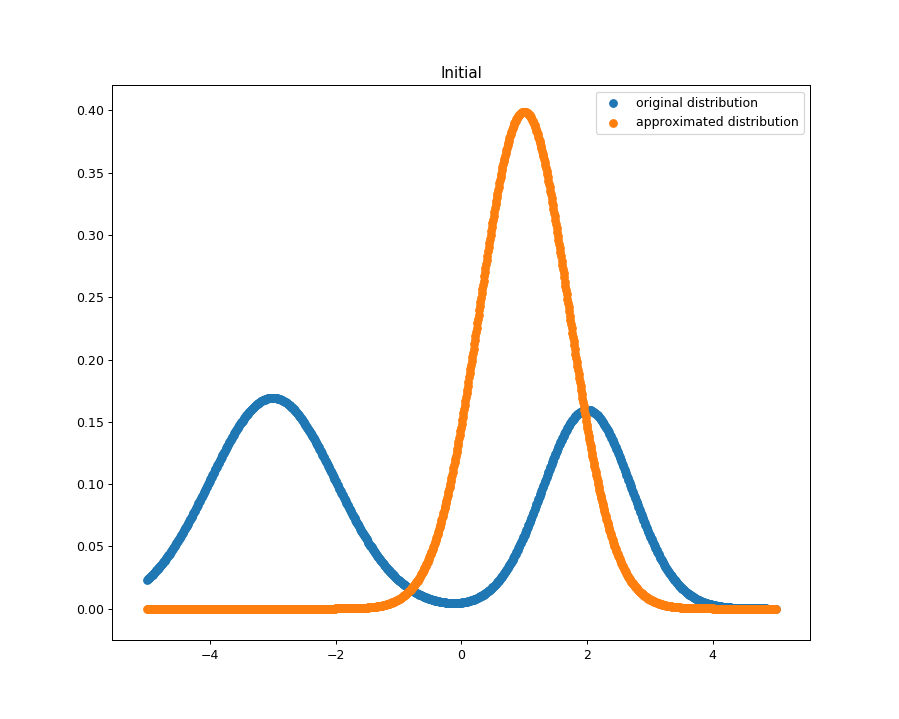

In [54]:
draw(p,iq)
plt.title('Initial')

<IPython.core.display.Javascript object>


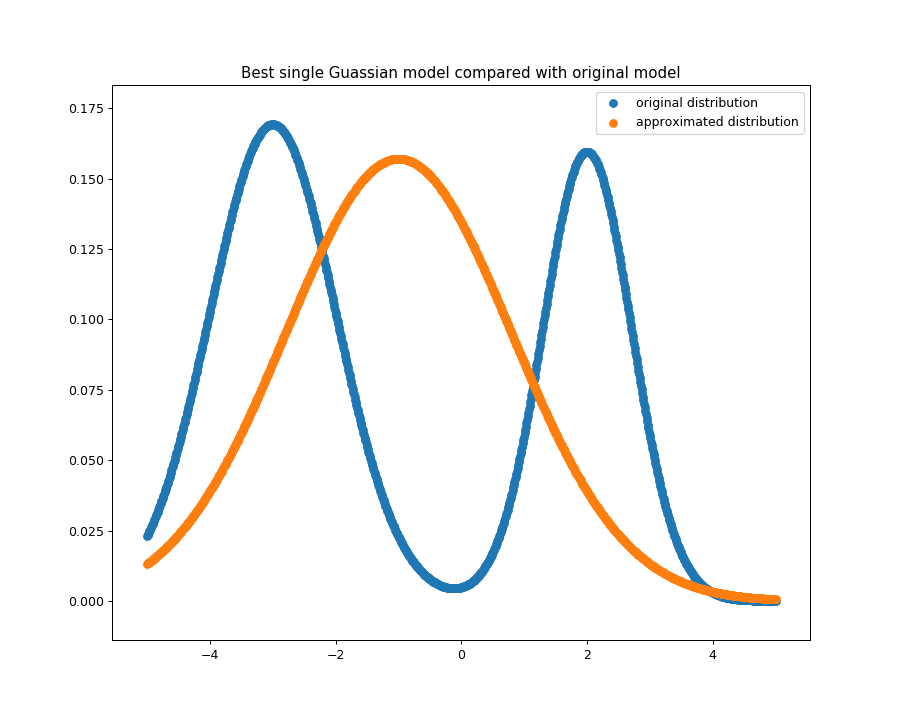

In [55]:
draw(p,q)
plt.title('Best single Guassian model compared with original model')

综上所述，在左KL散度作为衡量分布拟合的cost的情况下，单个高斯分布的模型的参数偏向：
* ${\mu}$ = pc1 * ${\mu_1}$ + pc2 * ${\mu_2}$
* ${var}$越大越好

## 在右KL散度的情况下，单个高斯分布模型拟合混合高斯分布模型的最优参数求解

In [56]:
def RKLcost_func(p):
    """在右KL散度的情况下，使用参数x得到的单个高斯分布模型
    去拟合混合高斯分布模型的cost
    """
    def __call__(x):
        q = OneDGaussian(*x)
        f = fullf(q,p)
        return quad(f, -20, 20)
    
    return __call__

In [57]:
def RKLcost_funcdd(p):
    """在右KL散度的情况下，使用参数x得到的单个高斯分布模型
    去拟合混合高斯分布模型的cost，不同的是x 仍然服从的是p的分布
    """
    def __call__(x):
        q = OneDGaussian(*x)
        f = Nakfullf(q,p)
        return quad(f, -20, 20)
    
    return __call__

In [58]:
costc = LKLcost_func(p)

In [59]:
cost = RKLcost_func(p)

In [60]:
cost([1,2])

1.4914927072683293

In [61]:
costc([1,2])

4.4585811910273083

同样的我们先查看不同参数下的偏导的情况

In [62]:
## 直观地感受cost随 均值和方差的变化图
u_x = np.linspace(2*u1, 2*u2, 100)
var_x = np.linspace(1, 2*2, 100)

cost 随均值的变化曲线

In [63]:
c = np.zeros_like(u_x)
for i, ux in enumerate(u_x):
    c[i] = cost((ux, var_x[-1]))

<IPython.core.display.Javascript object>


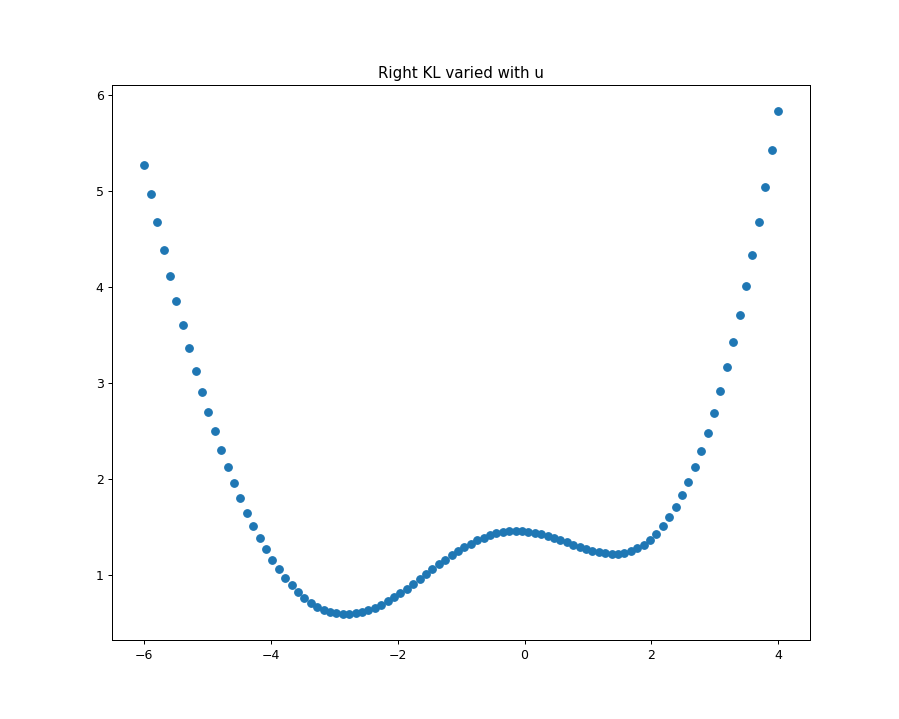

In [64]:
fig = plt.figure(figsize = (10,8))
plt.scatter(u_x, c)
plt.title('Right KL varied with u')

cost 随方差的变化曲线

In [65]:
c = np.zeros_like(var_x)
for i, varx in enumerate(var_x):
    c[i] = cost((u_x[-1], varx))

<IPython.core.display.Javascript object>


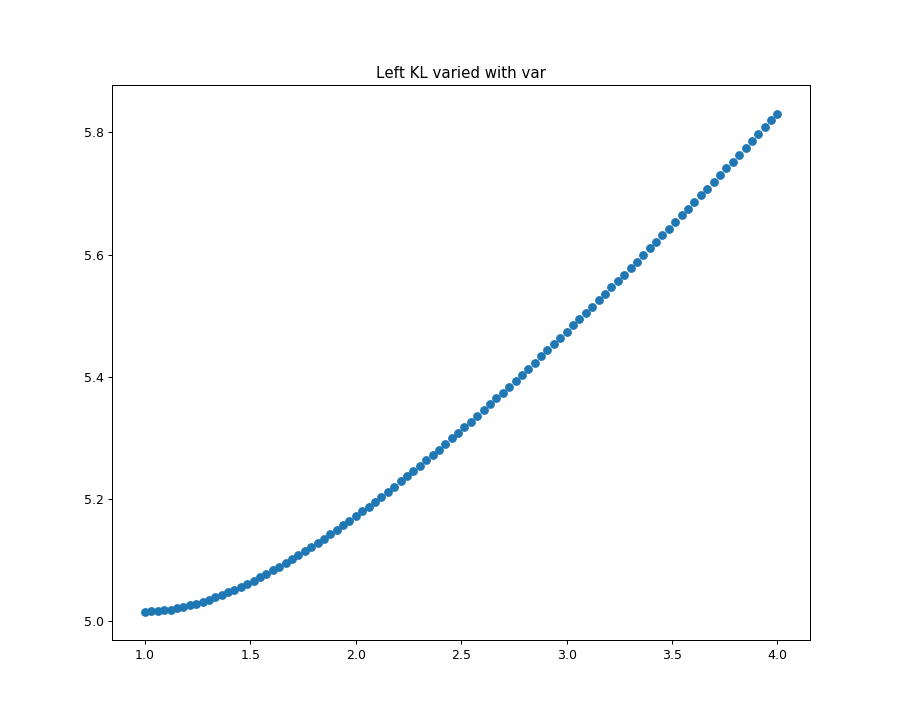

In [66]:
fig = plt.figure(figsize = (10,8))
plt.scatter(var_x, c)
plt.title('Left KL varied with var')

画出函数cost(x,y)的三维图像

In [68]:
# 画出函数cost(x,y)的三维图像
ux = np.linspace(2*u1, 2*u2, 100)
varx = np.linspace(1, 5, 100)
ux,varx = np.meshgrid(ux,varx)

In [69]:
z = np.zeros_like(ux)
m,n = z.shape
for i in range(m):
    for j in range(n):
        z[i,j] = cost((ux[i,j], varx[i,j]))

<IPython.core.display.Javascript object>


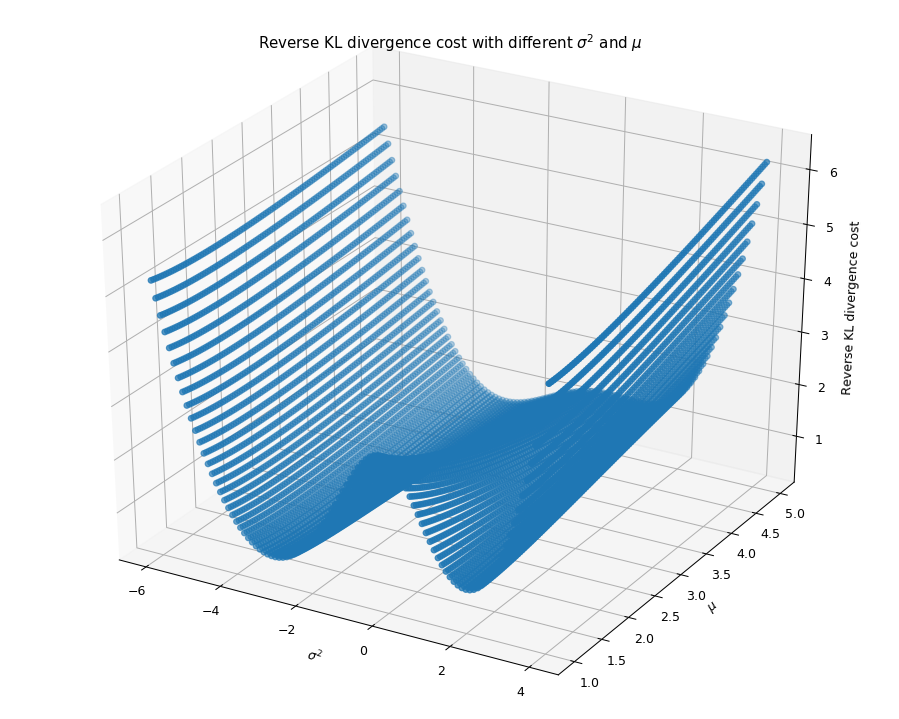

In [70]:
# plot
fig = plt.figure(figsize = (10,8))
ax = Axes3D(fig)
ax.set_zlabel('Reverse KL divergence cost')
ax.scatter(ux,varx, z)
plt.xlabel('${\sigma^{2}}$')
plt.ylabel('${\mu}$')
plt.title('Reverse KL divergence cost with different $\sigma^{2}$ and $\mu$')

规律不太明显，但是我们知道最优解应该是存在的

下面使用梯度下降求解

In [73]:
initial_x = np.array([-1,1])

In [74]:
c = GradientDescent(cost, initial_x, 0.001, iternum=10000)

[-1.0013066   1.00067051]
[-2.15018279  1.33510621]
[-2.68029959  1.46404289]
[-2.87923577  1.55487215]
[-2.95187556  1.62687583]
[-2.97787769  1.68626714]
[-2.98675999  1.73634217]
[-2.98938303  1.77918099]
[-2.98974278  1.81621537]
[-2.98931147  1.84848807]


In [75]:
c

array([-2.98863212,  1.87676299])

In [76]:
iq = OneDGaussian(*initial_x)
q = OneDGaussian(*c)

<IPython.core.display.Javascript object>


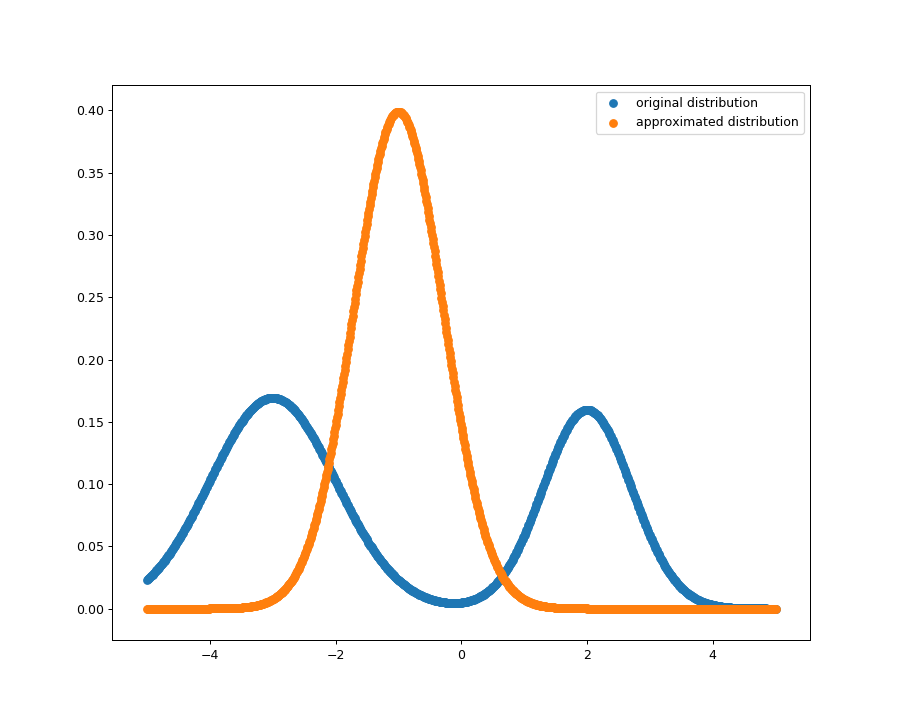

<module 'matplotlib.pyplot' from 'E:\\IDE\\Anaconda2\\envs\\python3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [77]:
draw(p,iq)

<IPython.core.display.Javascript object>


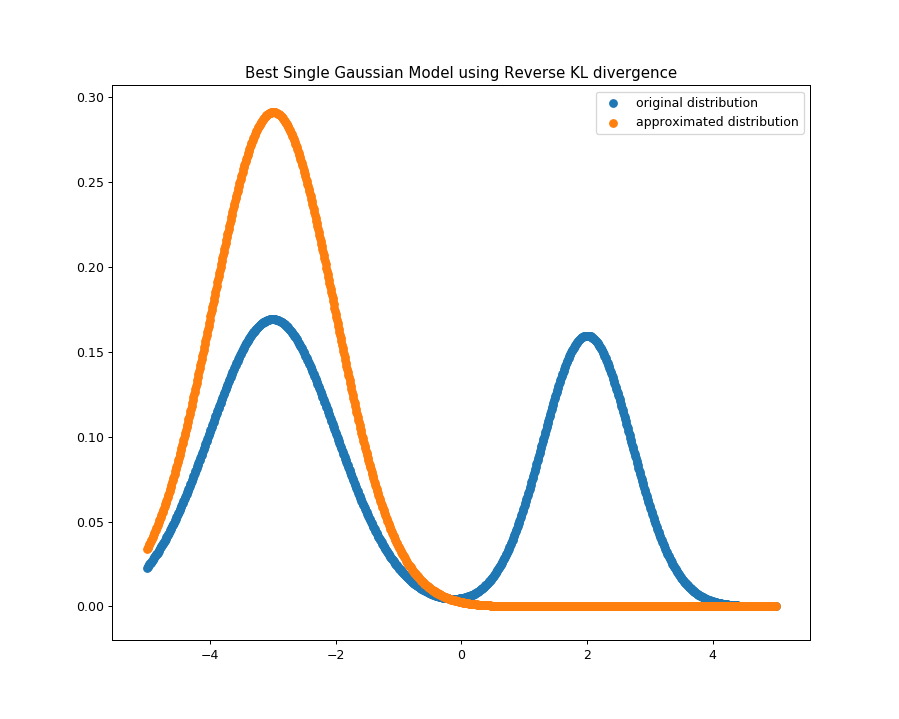

In [79]:
draw(p,q)
plt.title('Best Single Gaussian Model using Reverse KL divergence')

我们可以看到，此时最优的单个高斯分布会倾向于选择一个峰值